# Forecasting Model: MLB (Within Sample Forecast)

We will fit the forecasting model using the salary inforamtion as an IV and compare the performance of the salary forecasting model with betting odds model in terms of accuracy rate and Brier score.

Note. The salary information among MLB players were obtained from the web site below. The data were available before the regular season starts so it can be used to "predict" game results for the particular season in advance. Particularly, we used the avarage salary column in the page.
https://www.spotrac.com/mlb/contracts/

## 1. Data Preparation

### 1.1) Import Libraries & Dataset

In [1]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

In [2]:
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [3]:
####Import Data####
mlb = pd.read_csv("../../Data/Week 4/GL2019.csv")
salary = pd.read_csv("../../Data/Week 4/mlb_salaries_2019.csv")

#Display Data
display(mlb[0:10])
display(salary[0:10])

,date,game_number,day,visitor,visitor_lg,visitor_game_number,home,home_lg,home_game_number,visitor_score,...,home_batter_7_name,home_batter_7_pos,home_batter_8_id,home_batter_8_name,home_batter_8_pos,home_batter_9_id,home_batter_9_name,home_batter_9_pos,additional_info,acquisition
0,20190320,0,Wed,SEA,AL,1,OAK,AL,1,9,...,Jurickson Profar,4,semim001,Marcus Semien,6,hundn001,Nick Hundley,2,NaN,Y
1,20190321,0,Thu,SEA,AL,2,OAK,AL,2,5,...,Jurickson Profar,4,laurr001,Ramon Laureano,8,phegj001,Josh Phegley,2,NaN,Y
2,20190328,0,Thu,PIT,NL,1,CIN,NL,1,3,...,Tucker Barnhart,2,iglej001,Jose Iglesias,6,castl003,Luis Castillo,1,NaN,Y
3,20190328,0,Thu,ARI,NL,1,LAN,NL,1,5,...,Enrique Hernandez,4,barna001,Austin Barnes,2,ryu-h001,Hyun-Jin Ryu,1,NaN,Y
4,20190328,0,Thu,COL,NL,1,MIA,NL,1,6,...,Miguel Rojas,6,herrr002,Rosell Herrera,7,urenj001,Jose Urena,1,NaN,Y
5,20190328,0,Thu,SLN,NL,1,MIL,NL,1,4,...,Yasmani Grandal,2,arcio002,Orlando Arcia,6,chacj001,Jhoulys Chacin,1,NaN,Y
6,20190328,0,Thu,ATL,NL,1,PHI,NL,1,4,...,Cesar Hernandez,4,franm004,Maikel Franco,5,nolaa001,Aaron Nola,1,NaN,Y
7,20190328,0,Thu,SFN,NL,1,SDN,NL,1,0,...,Manuel Margot,8,hedga001,Austin Hedges,2,lauee001,Eric Lauer,1,NaN,Y
8,20190328,0,Thu,NYN,NL,1,WAS,NL,1,2,...,Brian Dozier,4,schem001,Max Scherzer,1,roblv001,Victor Robles,8,NaN,Y
9,20190328,0,Thu,CHA,AL,1,KCA,AL,1,3,...,Hunter Dozier,5,maldm001,Martin Maldonado,2,hamib001,Billy Hamilton,8,NaN,Y


,Team_Full,team,Payroll
0,Arizona Diamondbacks,ARI,123815766
1,Atlanta Braves,ATL,128247089
2,Baltimore Orioles,BAL,80814882
3,Boston Red Sox,BOS,236171428
4,Chicago Cubs,CHN,213643488
5,Chicago White Sox,CHA,88902000
6,Cincinnati Reds,CIN,126673214
7,Cleveland Indians,CLE,119575032
8,Colorado Rockies,COL,145248500
9,Detroit Tigers,DET,115673500


In [4]:
salary.describe().round(decimals = 0)

,Payroll
count,30.0
mean,134804609.0
std,44471994.0
min,60084133.0
25%,106021450.0
50%,125244490.0
75%,158669687.0
max,236171428.0


### 1.2) Data Cleaning and Organization
This proceeds in several steps:

>1. Select columns used for analysis.
>2. Manipulate the data to obtain the game results.
>3. Append the salary data for two teams in a match.

In [5]:
mlb = mlb[['date', 'home', 'visitor', 'visitor_score', 'home_score']]

In [6]:
display(mlb[0:10])

,date,home,visitor,visitor_score,home_score
0,20190320,OAK,SEA,9,7
1,20190321,OAK,SEA,5,4
2,20190328,CIN,PIT,3,5
3,20190328,LAN,ARI,5,12
4,20190328,MIA,COL,6,3
5,20190328,MIL,SLN,4,5
6,20190328,PHI,ATL,4,10
7,20190328,SDN,SFN,0,2
8,20190328,WAS,NYN,2,0
9,20190328,KCA,CHA,3,5


In [7]:
# Define run differentials and assign it into 'run_dff'
mlb['H_run_dff'] = mlb['home_score'] - mlb['visitor_score']

In [8]:
# Define the game results from run_dff (1: Win, 0: lose)
mlb['H_win'] = mlb['H_run_dff'].apply(lambda x: 1 if x > 0 else 0)

In [9]:
display(mlb[0:10])

,date,home,visitor,visitor_score,home_score,H_run_dff,H_win
0,20190320,OAK,SEA,9,7,-2,0
1,20190321,OAK,SEA,5,4,-1,0
2,20190328,CIN,PIT,3,5,2,1
3,20190328,LAN,ARI,5,12,7,1
4,20190328,MIA,COL,6,3,-3,0
5,20190328,MIL,SLN,4,5,1,1
6,20190328,PHI,ATL,4,10,6,1
7,20190328,SDN,SFN,0,2,2,1
8,20190328,WAS,NYN,2,0,-2,0
9,20190328,KCA,CHA,3,5,2,1


In [10]:
# Drop the unnecessary column in 'salary' data
salary.drop(columns = ['Team_Full'], inplace = True)

In [11]:
# Use 'team' column as a matching column when appending the salary data for home and visitor teams in a match.
## This means that you need to change the 'team' column one at a time for home and away team respectively. 
salary.rename(columns = {'team':'home'}, inplace = True)

In [12]:
display(salary[0:10])

,home,Payroll
0,ARI,123815766
1,ATL,128247089
2,BAL,80814882
3,BOS,236171428
4,CHN,213643488
5,CHA,88902000
6,CIN,126673214
7,CLE,119575032
8,COL,145248500
9,DET,115673500


In [13]:
# Merge salary data for home teams
mlb=pd.merge(mlb, salary, on=['home'])
mlb.head()

,date,home,visitor,visitor_score,home_score,H_run_dff,H_win,Payroll
0,20190320,OAK,SEA,9,7,-2,0,89135833
1,20190321,OAK,SEA,5,4,-1,0,89135833
2,20190328,OAK,ANA,0,4,4,1,89135833
3,20190329,OAK,ANA,6,2,-4,0,89135833
4,20190330,OAK,ANA,2,4,2,1,89135833


In [14]:
# Now, we need to change the 'home' column to 'visitor' as a matching column
salary.rename(columns = {'home':'visitor'}, inplace = True)

display(salary[0:10])

,visitor,Payroll
0,ARI,123815766
1,ATL,128247089
2,BAL,80814882
3,BOS,236171428
4,CHN,213643488
5,CHA,88902000
6,CIN,126673214
7,CLE,119575032
8,COL,145248500
9,DET,115673500


In [15]:
# Merge salary data for visitors
mlb=pd.merge(mlb, salary, on=['visitor'])
mlb.head()

,date,home,visitor,visitor_score,home_score,H_run_dff,H_win,Payroll_x,Payroll_y
0,20190320,OAK,SEA,9,7,-2,0,89135833,146498473
1,20190321,OAK,SEA,5,4,-1,0,89135833,146498473
2,20190524,OAK,SEA,2,6,4,1,89135833,146498473
3,20190525,OAK,SEA,5,6,1,1,89135833,146498473
4,20190526,OAK,SEA,1,7,6,1,89135833,146498473


In [16]:
# Change the column names properly
mlb.rename(columns={'Payroll_x':'hm_sal'}, inplace=True)
mlb.rename(columns={'Payroll_y':'vst_sal'}, inplace=True)

In [17]:
# Check out the resulting data frame
mlb.head()

,date,home,visitor,visitor_score,home_score,H_run_dff,H_win,hm_sal,vst_sal
0,20190320,OAK,SEA,9,7,-2,0,89135833,146498473
1,20190321,OAK,SEA,5,4,-1,0,89135833,146498473
2,20190524,OAK,SEA,2,6,4,1,89135833,146498473
3,20190525,OAK,SEA,5,6,1,1,89135833,146498473
4,20190526,OAK,SEA,1,7,6,1,89135833,146498473


In [18]:
# Take the log of salay to be used as I.V for regression
mlb['lg_hm_sal']=np.log(mlb['hm_sal'])
mlb['lg_vst_sal']=np.log(mlb['vst_sal'])
mlb['lg_ratio']=mlb['lg_hm_sal']-mlb['lg_vst_sal']

In [19]:
display(mlb[0:10])

,date,home,visitor,visitor_score,home_score,H_run_dff,H_win,hm_sal,vst_sal,lg_hm_sal,lg_vst_sal,lg_ratio
0,20190320,OAK,SEA,9,7,-2,0,89135833,146498473,18.305672,18.802526,-0.496854
1,20190321,OAK,SEA,5,4,-1,0,89135833,146498473,18.305672,18.802526,-0.496854
2,20190524,OAK,SEA,2,6,4,1,89135833,146498473,18.305672,18.802526,-0.496854
3,20190525,OAK,SEA,5,6,1,1,89135833,146498473,18.305672,18.802526,-0.496854
4,20190526,OAK,SEA,1,7,6,1,89135833,146498473,18.305672,18.802526,-0.496854
5,20190614,OAK,SEA,9,2,-7,0,89135833,146498473,18.305672,18.802526,-0.496854
6,20190615,OAK,SEA,2,11,9,1,89135833,146498473,18.305672,18.802526,-0.496854
7,20190616,OAK,SEA,6,3,-3,0,89135833,146498473,18.305672,18.802526,-0.496854
8,20190716,OAK,SEA,2,9,7,1,89135833,146498473,18.305672,18.802526,-0.496854
9,20190717,OAK,SEA,2,10,8,1,89135833,146498473,18.305672,18.802526,-0.496854


## 2. Forecasting with Linear Model

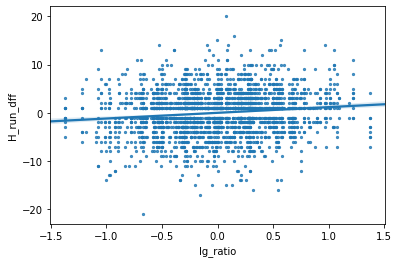

In [20]:
# Scatter plot 
sns.regplot(x = 'lg_ratio', y = 'H_run_dff', data = mlb, scatter_kws={'s':5})

In [21]:
# Forecasting with Linear Regression
RDreg = smf.ols(formula = 'H_run_dff ~ lg_ratio', data=mlb).fit()
RDreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              H_run_dff   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     38.50
Date:                Fri, 05 Mar 2021   Prob (F-statistic):           6.42e-10
Time:                        10:57:31   Log-Likelihood:                -7153.4
No. Observations:                2429   AIC:                         1.431e+04
Df Residuals:                    2427   BIC:                         1.432e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0121      0.093     -0.129      0.897      -0.195       0.171
lg_ratio       1.1822      0.191      6.205      0.000       0.809       1.556
==============================================================================
Omnibus:                       35.991   Durbin-Watson:                   1.915
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               59.656
Skew:                          -0.106   Prob(JB):                     1.11e-13
Kurtosis:                       3.738   Cond. No.                         2.04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
# Obtain the fitted results
mlb['RDpred'] = RDreg.predict()
mlb.head()

,date,home,visitor,visitor_score,home_score,H_run_dff,H_win,hm_sal,vst_sal,lg_hm_sal,lg_vst_sal,lg_ratio,RDpred
0,20190320,OAK,SEA,9,7,-2,0,89135833,146498473,18.305672,18.802526,-0.496854,-0.599469
1,20190321,OAK,SEA,5,4,-1,0,89135833,146498473,18.305672,18.802526,-0.496854,-0.599469
2,20190524,OAK,SEA,2,6,4,1,89135833,146498473,18.305672,18.802526,-0.496854,-0.599469
3,20190525,OAK,SEA,5,6,1,1,89135833,146498473,18.305672,18.802526,-0.496854,-0.599469
4,20190526,OAK,SEA,1,7,6,1,89135833,146498473,18.305672,18.802526,-0.496854,-0.599469


In [23]:
#If the fitted RD >0, we predict team win (1), otherwise opp win(0)
mlb['res_RDpred'] = np.where(mlb['RDpred']>0, 1, 0)
mlb.head()

,date,home,visitor,visitor_score,home_score,H_run_dff,H_win,hm_sal,vst_sal,lg_hm_sal,lg_vst_sal,lg_ratio,RDpred,res_RDpred
0,20190320,OAK,SEA,9,7,-2,0,89135833,146498473,18.305672,18.802526,-0.496854,-0.599469,0
1,20190321,OAK,SEA,5,4,-1,0,89135833,146498473,18.305672,18.802526,-0.496854,-0.599469,0
2,20190524,OAK,SEA,2,6,4,1,89135833,146498473,18.305672,18.802526,-0.496854,-0.599469,0
3,20190525,OAK,SEA,5,6,1,1,89135833,146498473,18.305672,18.802526,-0.496854,-0.599469,0
4,20190526,OAK,SEA,1,7,6,1,89135833,146498473,18.305672,18.802526,-0.496854,-0.599469,0


In [24]:
# Obtain the correct predictions and success rate
mlb['RDcorrect'] = np.where(mlb['res_RDpred'] == mlb['H_win'], 1, 0)
sum(mlb['RDcorrect'])/2429

0.5566076574722107

## 3. Forecasting with Logistic Regression

In [25]:
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [26]:
# Specify the model and then run logistic regression
H_Win_Lg = 'H_win~lg_ratio'
model = smf.glm(formula = H_Win_Lg, data = mlb, family=sm.families.Binomial())
result = model.fit()

# Print the result
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  H_win   No. Observations:                 2429
Model:                            GLM   Df Residuals:                     2427
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1666.2
Date:                Fri, 05 Mar 2021   Deviance:                       3332.4
Time:                        10:57:34   Pearson chi2:                 2.43e+03
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1191      0.041      2.914      0.0

In [27]:
# obtain the fitted probabilities of winning on each game by using the logit model
fittedProbs = result.predict()
print(fittedProbs[0:10])

[0.47634418 0.47634418 0.47634418 0.47634418 0.47634418 0.47634418
 0.47634418 0.47634418 0.47634418 0.47634418]


In [28]:
# Create a binary winning variable by using the fitted probabilities
fittedWin = [1 if x > .5 else 0 for x in fittedProbs]
print(fittedWin[0:10])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [29]:
from sklearn.metrics import confusion_matrix, classification_report
confusion_matrix(mlb['H_win'], fittedWin)

array([[391, 752],
       [338, 948]], dtype=int64)

In [30]:
(391+948)/2429

0.5512556607657472

In [31]:
print(classification_report(mlb['H_win'], fittedWin, digits=3))

              precision    recall  f1-score   support

           0      0.536     0.342     0.418      1143
           1      0.558     0.737     0.635      1286

    accuracy                          0.551      2429
   macro avg      0.547     0.540     0.526      2429
weighted avg      0.548     0.551     0.533      2429



### Self Test:
Obtain the fitted probabilities using the formula above, and then create the predicted game results. Compare the success rate and see if you get the identical results.

In [32]:
#Your Code Here

In [33]:
mlb['pred_Home_W'] = 1/(1+np.exp(-(0.119124+ 0.430343*mlb['lg_ratio'])))
mlb['pred_Home_L'] = 1- mlb['pred_Home_W'] 
display(mlb[0:10])

,date,home,visitor,visitor_score,home_score,H_run_dff,H_win,hm_sal,vst_sal,lg_hm_sal,lg_vst_sal,lg_ratio,RDpred,res_RDpred,RDcorrect,pred_Home_W,pred_Home_L
0,20190320,OAK,SEA,9,7,-2,0,89135833,146498473,18.305672,18.802526,-0.496854,-0.599469,0,1,0.476344,0.523656
1,20190321,OAK,SEA,5,4,-1,0,89135833,146498473,18.305672,18.802526,-0.496854,-0.599469,0,1,0.476344,0.523656
2,20190524,OAK,SEA,2,6,4,1,89135833,146498473,18.305672,18.802526,-0.496854,-0.599469,0,0,0.476344,0.523656
3,20190525,OAK,SEA,5,6,1,1,89135833,146498473,18.305672,18.802526,-0.496854,-0.599469,0,0,0.476344,0.523656
4,20190526,OAK,SEA,1,7,6,1,89135833,146498473,18.305672,18.802526,-0.496854,-0.599469,0,0,0.476344,0.523656
5,20190614,OAK,SEA,9,2,-7,0,89135833,146498473,18.305672,18.802526,-0.496854,-0.599469,0,1,0.476344,0.523656
6,20190615,OAK,SEA,2,11,9,1,89135833,146498473,18.305672,18.802526,-0.496854,-0.599469,0,0,0.476344,0.523656
7,20190616,OAK,SEA,6,3,-3,0,89135833,146498473,18.305672,18.802526,-0.496854,-0.599469,0,1,0.476344,0.523656
8,20190716,OAK,SEA,2,9,7,1,89135833,146498473,18.305672,18.802526,-0.496854,-0.599469,0,0,0.476344,0.523656
9,20190717,OAK,SEA,2,10,8,1,89135833,146498473,18.305672,18.802526,-0.496854,-0.599469,0,0,0.476344,0.523656


In [34]:
mlb.loc[mlb.pred_Home_L > mlb.pred_Home_W, 'fitted'] = 0
mlb.loc[mlb.pred_Home_W > mlb.pred_Home_L, 'fitted'] = 1

In [35]:
mlb['TRUE'] = np.where(mlb['fitted']==mlb['H_win'], 1, 0)
display(mlb[0:10])

,date,home,visitor,visitor_score,home_score,H_run_dff,H_win,hm_sal,vst_sal,lg_hm_sal,lg_vst_sal,lg_ratio,RDpred,res_RDpred,RDcorrect,pred_Home_W,pred_Home_L,fitted,TRUE
0,20190320,OAK,SEA,9,7,-2,0,89135833,146498473,18.305672,18.802526,-0.496854,-0.599469,0,1,0.476344,0.523656,0.0,1
1,20190321,OAK,SEA,5,4,-1,0,89135833,146498473,18.305672,18.802526,-0.496854,-0.599469,0,1,0.476344,0.523656,0.0,1
2,20190524,OAK,SEA,2,6,4,1,89135833,146498473,18.305672,18.802526,-0.496854,-0.599469,0,0,0.476344,0.523656,0.0,0
3,20190525,OAK,SEA,5,6,1,1,89135833,146498473,18.305672,18.802526,-0.496854,-0.599469,0,0,0.476344,0.523656,0.0,0
4,20190526,OAK,SEA,1,7,6,1,89135833,146498473,18.305672,18.802526,-0.496854,-0.599469,0,0,0.476344,0.523656,0.0,0
5,20190614,OAK,SEA,9,2,-7,0,89135833,146498473,18.305672,18.802526,-0.496854,-0.599469,0,1,0.476344,0.523656,0.0,1
6,20190615,OAK,SEA,2,11,9,1,89135833,146498473,18.305672,18.802526,-0.496854,-0.599469,0,0,0.476344,0.523656,0.0,0
7,20190616,OAK,SEA,6,3,-3,0,89135833,146498473,18.305672,18.802526,-0.496854,-0.599469,0,1,0.476344,0.523656,0.0,1
8,20190716,OAK,SEA,2,9,7,1,89135833,146498473,18.305672,18.802526,-0.496854,-0.599469,0,0,0.476344,0.523656,0.0,0
9,20190717,OAK,SEA,2,10,8,1,89135833,146498473,18.305672,18.802526,-0.496854,-0.599469,0,0,0.476344,0.523656,0.0,0


In [36]:
Total = mlb['TRUE'].sum()
print(Total/2429)

0.5512556607657472


## 4. Forecasting with Betting Odds

In [37]:
# Import betting odds data
MLB_odds = pd.read_excel("../../Data/Week 4/MLB2019odds.xlsx")

display(MLB_odds[0:10])

,team,opponent,day,month,home,oddsfor,oddsagainst,runsfor,runsagainst,win,game home team- away team,score,date
0,Arizona Diamondbacks,Atlanta Braves,10,5,1,1.91,1.92,3,2,1,Arizona Diamondbacks - Atlanta Braves,03:02:00,10.05.
1,Arizona Diamondbacks,Atlanta Braves,11,5,1,1.73,2.14,1,2,0,Arizona Diamondbacks - Atlanta Braves,01:02:00,11.05.
2,Arizona Diamondbacks,Atlanta Braves,12,5,1,2.03,1.82,3,5,0,Arizona Diamondbacks - Atlanta Braves,03:05:00,12.05.
3,Arizona Diamondbacks,Atlanta Braves,12,5,1,2.06,1.79,4,6,0,Arizona Diamondbacks - Atlanta Braves,04:06:00,12.05.
4,Arizona Diamondbacks,Baltimore Orioles,23,7,1,1.39,3.08,6,3,1,Arizona Diamondbacks - Baltimore Orioles,06:03:00,23.07.
5,Arizona Diamondbacks,Baltimore Orioles,24,7,1,1.52,2.57,2,7,0,Arizona Diamondbacks - Baltimore Orioles,02:07:00,24.07.
6,Arizona Diamondbacks,Baltimore Orioles,24,7,1,1.66,2.25,5,2,1,Arizona Diamondbacks - Baltimore Orioles,05:02:00,24.07.
7,Arizona Diamondbacks,Boston Red Sox,6,4,1,2.11,1.76,15,8,1,Arizona Diamondbacks - Boston Red Sox,15:08:00,06.04.
8,Arizona Diamondbacks,Boston Red Sox,7,4,1,1.95,1.89,0,1,0,Arizona Diamondbacks - Boston Red Sox,00:01:00,07.04.
9,Arizona Diamondbacks,Boston Red Sox,7,4,1,2.17,1.72,5,4,1,Arizona Diamondbacks - Boston Red Sox,05:04:00,07.04.


In [38]:
# Obtain the fitted probabilities from betting odds
MLB_odds['winprob']= 1/(MLB_odds['oddsfor'])/(1/(MLB_odds['oddsfor'])+ 1/(MLB_odds['oddsagainst']))

In [39]:
display(MLB_odds[0:10])

,team,opponent,day,month,home,oddsfor,oddsagainst,runsfor,runsagainst,win,game home team- away team,score,date,winprob
0,Arizona Diamondbacks,Atlanta Braves,10,5,1,1.91,1.92,3,2,1,Arizona Diamondbacks - Atlanta Braves,03:02:00,10.05.,0.501305
1,Arizona Diamondbacks,Atlanta Braves,11,5,1,1.73,2.14,1,2,0,Arizona Diamondbacks - Atlanta Braves,01:02:00,11.05.,0.552972
2,Arizona Diamondbacks,Atlanta Braves,12,5,1,2.03,1.82,3,5,0,Arizona Diamondbacks - Atlanta Braves,03:05:00,12.05.,0.472727
3,Arizona Diamondbacks,Atlanta Braves,12,5,1,2.06,1.79,4,6,0,Arizona Diamondbacks - Atlanta Braves,04:06:00,12.05.,0.464935
4,Arizona Diamondbacks,Baltimore Orioles,23,7,1,1.39,3.08,6,3,1,Arizona Diamondbacks - Baltimore Orioles,06:03:00,23.07.,0.689038
5,Arizona Diamondbacks,Baltimore Orioles,24,7,1,1.52,2.57,2,7,0,Arizona Diamondbacks - Baltimore Orioles,02:07:00,24.07.,0.628362
6,Arizona Diamondbacks,Baltimore Orioles,24,7,1,1.66,2.25,5,2,1,Arizona Diamondbacks - Baltimore Orioles,05:02:00,24.07.,0.575448
7,Arizona Diamondbacks,Boston Red Sox,6,4,1,2.11,1.76,15,8,1,Arizona Diamondbacks - Boston Red Sox,15:08:00,06.04.,0.454780
8,Arizona Diamondbacks,Boston Red Sox,7,4,1,1.95,1.89,0,1,0,Arizona Diamondbacks - Boston Red Sox,00:01:00,07.04.,0.492188
9,Arizona Diamondbacks,Boston Red Sox,7,4,1,2.17,1.72,5,4,1,Arizona Diamondbacks - Boston Red Sox,05:04:00,07.04.,0.442159


In [40]:
# Generate the team level data
MLBteamprobs=MLB_odds.groupby('team')[['winprob','win']].mean()

display(MLBteamprobs[0:10])

,winprob,win
team,,
Arizona Diamondbacks,0.490848,0.524691
Atlanta Braves,0.540956,0.598765
Baltimore Orioles,0.374573,0.333333
Boston Red Sox,0.579134,0.518519
Chicago Cubs,0.539655,0.518519
Chicago White Sox,0.426492,0.444444
Cincinnati Reds,0.491491,0.462963
Cleveland Indians,0.571819,0.574074
Colorado Rockies,0.458536,0.438272


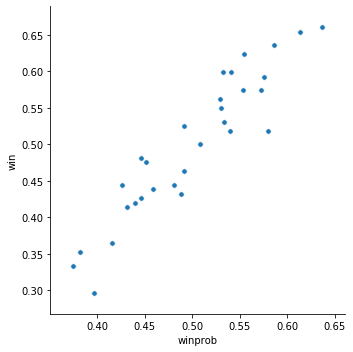

In [41]:
#scatter plot:
sns.relplot(x="winprob", y="win", data = MLBteamprobs, s=30)

In [42]:
# Obtain the predicted game results from the winning probabilities
MLB_odds['winpred'] = np.where(MLB_odds['winprob'] >= .5,1,0)

In [43]:
MLB_odds['TRUE'] = np.where(MLB_odds['winpred']==MLB_odds['win'], 1, 0)
MLB_odds.head()

,team,opponent,day,month,home,oddsfor,oddsagainst,runsfor,runsagainst,win,game home team- away team,score,date,winprob,winpred,TRUE
0,Arizona Diamondbacks,Atlanta Braves,10,5,1,1.91,1.92,3,2,1,Arizona Diamondbacks - Atlanta Braves,03:02:00,10.05.,0.501305,1,1
1,Arizona Diamondbacks,Atlanta Braves,11,5,1,1.73,2.14,1,2,0,Arizona Diamondbacks - Atlanta Braves,01:02:00,11.05.,0.552972,1,0
2,Arizona Diamondbacks,Atlanta Braves,12,5,1,2.03,1.82,3,5,0,Arizona Diamondbacks - Atlanta Braves,03:05:00,12.05.,0.472727,0,1
3,Arizona Diamondbacks,Atlanta Braves,12,5,1,2.06,1.79,4,6,0,Arizona Diamondbacks - Atlanta Braves,04:06:00,12.05.,0.464935,0,1
4,Arizona Diamondbacks,Baltimore Orioles,23,7,1,1.39,3.08,6,3,1,Arizona Diamondbacks - Baltimore Orioles,06:03:00,23.07.,0.689038,1,1


In [44]:
Total = MLB_odds['TRUE'].sum()
print(Total/4860)

0.6018518518518519


### Betting odds model predicted 60% of the results correctly while Salary ratio model predicted 55% results correctly

## 5. Brier Score for Each Model: Salary Model vs. Betting Odds Model

### 5.1) Brier Score for Salary Ratio Model

In [45]:
mlb['Houtcome'] = np.where(mlb['H_win'] == 1, 1,0)
mlb['Voutcome'] = np.where(mlb['H_win'] == 0, 1,0)

In [46]:
mlb['BrierLogit'] = (mlb['pred_Home_W'] - mlb['Houtcome'])**2 + (mlb['pred_Home_L'] - mlb['Voutcome'])**2

mlb['BrierLogit'].mean()

0.4928250651883045

### 5.2) Brier Score for Betting Odds Model

In [47]:
# Obtain the Brier score for betting odds
# NOTE. You already obtained the Brier score of betting odds for MLB 2019 in Week 2 (Please refer to the Self-Practice in Week 2)

MLB_odds['Brier']= (MLB_odds['win']-MLB_odds['winprob'])**2 + ((1-MLB_odds['win'])-(1-MLB_odds['winprob']))**2
MLB_odds['Brier'].mean()    

0.47138210629045985

### Brier score also indicates that the betting odds model (.47) is more accurate than the salary ratio model (.49).

## The End